In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import axes3d
import sklearn
import matplotlib.cm as cm
from sklearn.cluster import KMeans,OPTICS,DBSCAN

In [116]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.solver)

<module 'cebra_v2.solver' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/solver.py'>

## Utilitaires

In [107]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Data Loading

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [4]:
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"] == "jade"].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))

In [5]:
def STRUCTURE(x,y):
        return 1 - package.preprocessing.structure(x,y,is_batch = False)

metric = STRUCTURE

In [5]:
n_wins = 464
dfc_awake = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana', 'jade']) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_anaesthesized = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana', 'jade']) & (meta["condition"].isin(['awake']))].reshape((-1, n_wins, 82, 82))
dfc_train_anaesthesized = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_train_awake = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake']))].reshape((-1, n_wins, 82, 82))
dfc_test_awake = dfc[(meta["monkey"].isin(['jade'])) & (meta["condition"] == "awake")].reshape(-1,n_wins,82,82)
dfc_test_light_propofol = dfc[(meta["monkey"].isin(['jade'])) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape(-1,n_wins,82,82)

## Cebra

In [6]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1, "awake" : 2}

In [7]:
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["light-propofol","deep-propofol","awake"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

In [8]:
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["light-propofol","deep-propofol","awake"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

In [117]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        100,
    ),
    nn.Dropout(0.2),
    nn.GELU(),
    nn.Linear(
        100,
        20,
    ),
    nn.GELU(),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True,
    initialization = "default"
        )

In [91]:
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol', 'deep-propofol','awake']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol', 'deep-propofol','awake']))].reshape((-1, n_wins, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
discrete = labels_train

In [11]:
fc_train = torch.squeeze(fc_train,dim=2)
fc_train_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_train))

In [118]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector) #,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 2, batch_size = 10, matrix_delta = 0.5)

In [119]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'euclidean', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 10,learning_rate = 3e0, model = model)

In [123]:
cebra_fc.fit(fc_loader)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<LinalgVectorNormBackward0>)
Epoch 0
Train loss 17.2559, Train accuracy 0.00%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<LinalgVectorNormBackward0>)


In [124]:
model(fc_dataset.neural[0])

tensor([[-0.1126,  0.4701, -0.8754],
        [-0.1620,  0.3514, -0.9221],
        [-0.3863,  0.5817, -0.7158],
        ...,
        [-0.6455,  0.5747, -0.5030],
        [-0.5406,  0.6506, -0.5334],
        [-0.4960,  0.6757, -0.5454]], grad_fn=<DivBackward0>)

In [125]:
np.linalg.norm(np.array([-0.1126,  0.4701, -0.8754]))

0.9999989649994644

In [126]:
fc_emb = _compute_emissions_single(cebra_fc, fc_dataset.neural.reshape(-1,3321)).reshape(-1,464,3)

/tmp/ipykernel_25040/1432481655.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


"\nblack_patch = mpatches.Patch(color='black', label='light-propofol')\nred_patch = mpatches.Patch(color='red', label='deep-propofol')\ngreen_patch = mpatches.Patch(color='green', label='awake')\nax1.legend(handles=[black_patch,red_patch,green_patch])\n"

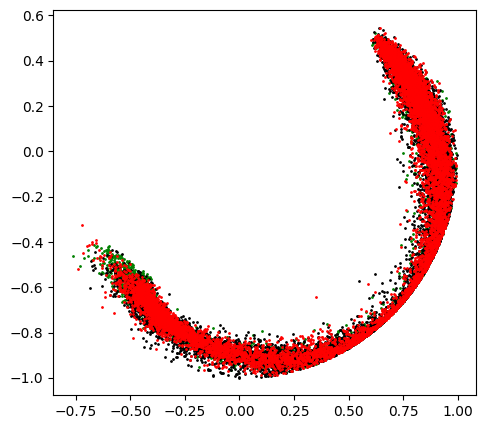

In [128]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(56):
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
green_patch = mpatches.Patch(color='green', label='awake')
ax1.legend(handles=[black_patch,red_patch,green_patch])
"""

/tmp/ipykernel_25040/1987381776.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


(-0.2909647703170776,
 0.2351615309715271,
 -0.23940083682537078,
 0.19617283642292022)

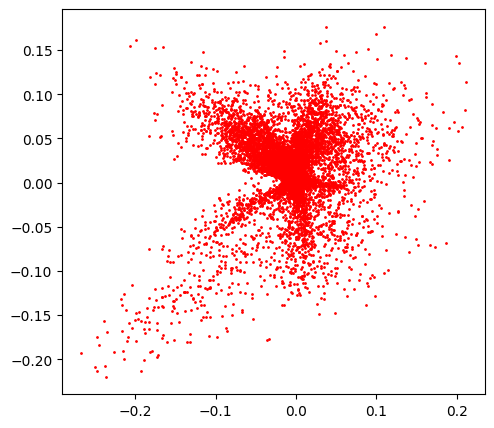

In [39]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(56):
    if labels_train[i,0] == 1:
        ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

/tmp/ipykernel_18949/3458737699.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


(-0.12914959713816643,
 0.15456562861800194,
 -0.2149986606091261,
 0.09221973083913326)

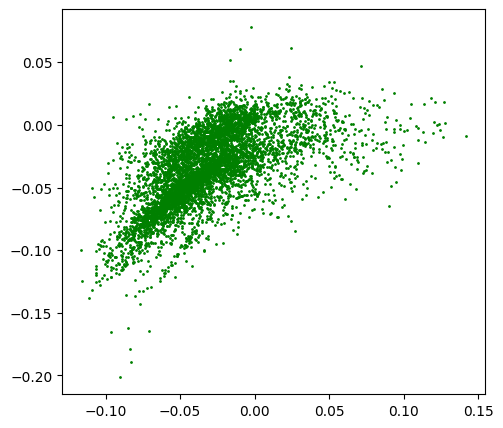

In [233]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(56):
    if labels_train[i,0] == 2:
        ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

In [204]:
dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
dfc_test_vector = dfc_test_vector.type(torch.float32)

In [205]:
#dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
a,b,c = dfc_test_vector.shape
data = dfc_test_vector.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)

/tmp/ipykernel_18949/48964752.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)


'\nblack_patch = mpatches.Patch(color=\'black\', label=\'light-propofol\')\nred_patch = mpatches.Patch(color=\'red\', label=\'deep-propofol\')\ngreen_patch = mpatches.Patch(color=\'green\', label=\'awake\')\nax1.legend(loc = "upper left",handles=[black_patch,red_patch,green_patch])\n'

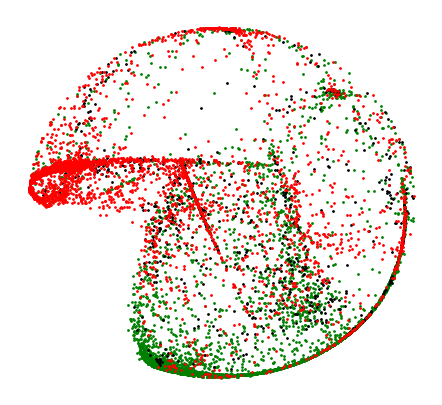

In [206]:
a,b,c = dfc_test_vector.shape
data = dfc_test_vector.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(28):
    if labels_test[i,0] in [0,1,2]:
        ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')
"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
green_patch = mpatches.Patch(color='green', label='awake')
ax1.legend(loc = "upper left",handles=[black_patch,red_patch,green_patch])
"""

In [46]:
torch.save(cebra_fc.model.state_dict(), '/volatile/aurelien_stumpf_mascles/project/models/model.pth')

## Clustering

For n_clusters = 20 The average silhouette_score is : 0.5831972


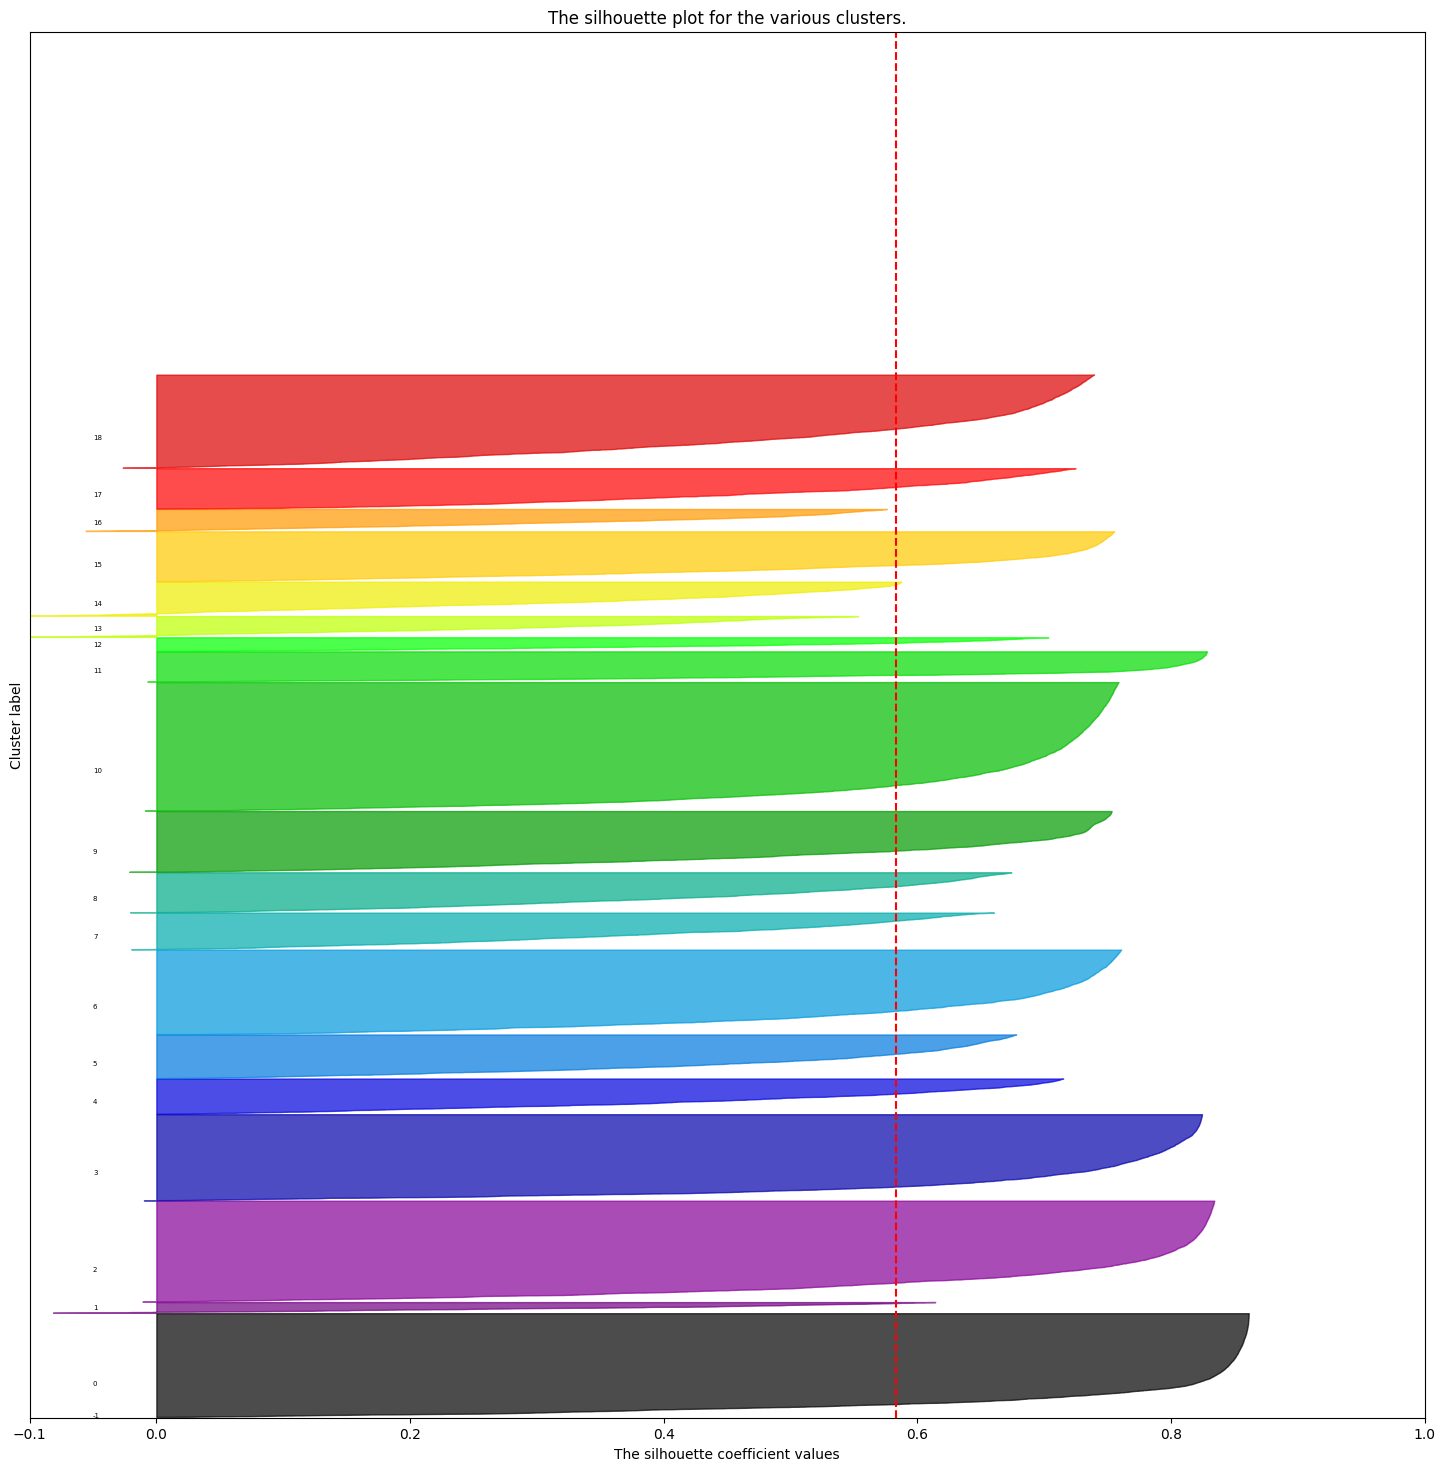

In [218]:
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

X = fc_emb.reshape(-1,3)

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
#clustering = DBSCAN(eps=0.1, min_samples=4).fit(X)
#clustering = OPTICS(min_samples=20, min_cluster_size = 40).fit(X)
clustering = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(X)
cluster_labels = clustering.labels_
n_clusters = len(np.unique(cluster_labels))

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, 1.3*len(X)])

y_lower = 10
for i in range(-1,n_clusters-1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=5)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

/volatile/aurelien_stumpf_mascles/project/env/lib/python3.8/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


"\nblack_patch = mpatches.Patch(color='black', label='light-propofol')\nred_patch = mpatches.Patch(color='red', label='deep-propofol')\ngreen_patch = mpatches.Patch(color='green', label='awake')\nax1.legend(handles=[black_patch,red_patch,green_patch])\n"

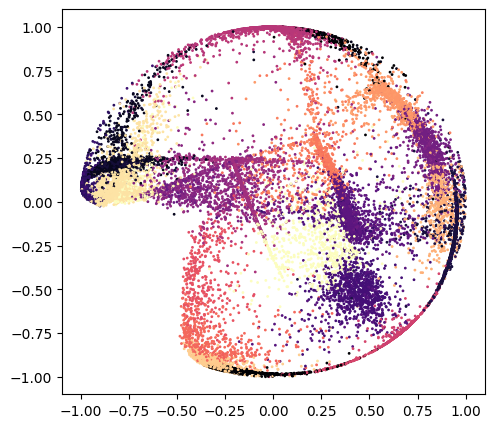

In [219]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))
labels = cluster_labels.reshape(-1,464)

ax1 = plt.subplot(121)
colors = np.array(["black",'red','green',"blue"])
for i in range(56):
    if True:
        ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = "magma", c = labels[i,:]+1, s=1)
#ax1.xticks() 
ax1.axis('on')

"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
green_patch = mpatches.Patch(color='green', label='awake')
ax1.legend(handles=[black_patch,red_patch,green_patch])
"""

In [213]:
def display(states,li_titles):
    fig = plt.figure(figsize=(11, 11))
    
    # setting values to rows and column variables
    n = len(states)
    rows = int(np.sqrt(n))+1
    columns = n // (rows-1)
    
    for i in range(n):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(states[i],cmap="hot")
        plt.axis('off')
        plt.title(li_titles[i])

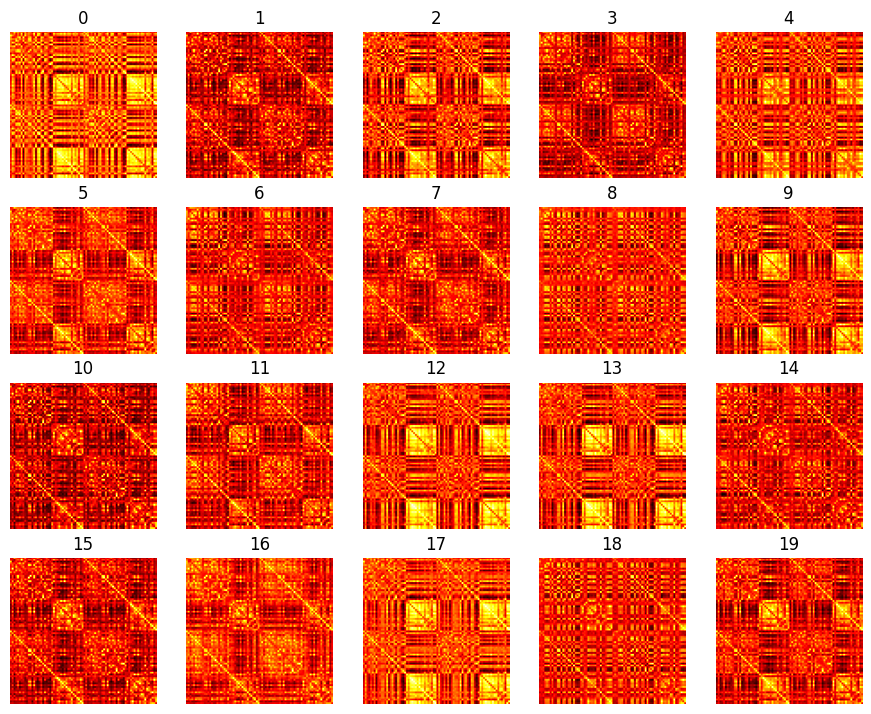

In [220]:
list_label = clustering.labels_
data = fc_train.reshape(-1,82,82).numpy()
mean_states = np.array([np.mean(data[clustering.labels_ == i],axis=0) for i in np.unique(clustering.labels_)])
display(mean_states,np.unique(clustering.labels_))

### Algorithme de classification

In [68]:
net = package.torch_classifier.MLP(input_dim = 3,output_dim = 3)
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
X = fc_emb.reshape((-1,3))
y = labels_train.reshape((-1))

d,e,f = dfc_test_vector.shape
data = dfc_test_vector.resize(d*e,f)
fc_emb = _compute_emissions_single(cebra_fc, data)
X_test = fc_emb.reshape((-1,3))
y_test = labels_train.reshape((-1))

#X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
train = package.torch_classifier.SimpleDataset(X,y)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 3, n_samples = 500)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [69]:
package.torch_classifier.Train(net,train_loader,test_loader,100,lr = 0.01)

Train loss 1.0915, Train accuracy 33.34%
Test accuracy 10.06%
Train loss 1.0369, Train accuracy 37.90%
Test accuracy 24.39%
Train loss 1.0356, Train accuracy 38.65%
Test accuracy 26.13%
Train loss 1.0348, Train accuracy 38.53%
Test accuracy 25.48%
Train loss 1.0341, Train accuracy 38.33%
Test accuracy 24.64%
Train loss 0.9429, Train accuracy 41.01%
Test accuracy 36.78%
Train loss 0.8940, Train accuracy 41.27%
Test accuracy 39.36%
Train loss 0.8887, Train accuracy 41.17%
Test accuracy 39.65%
Train loss 0.8872, Train accuracy 41.07%
Test accuracy 40.32%
Train loss 0.8838, Train accuracy 41.49%
Test accuracy 39.72%
End of training.



(-1.1, 1.1, -1.0999848204440221, 1.0999848204440221)

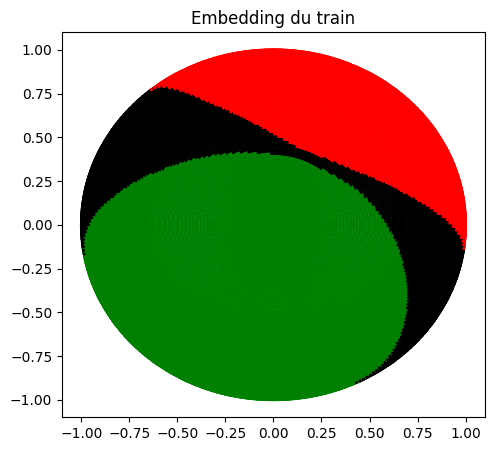

In [70]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,300),np.linspace(0,-np.pi,200))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

net.eval()
probas = torch.exp(net(torch.from_numpy(sphere).type(torch.float32)))
res = torch.argmax(probas,dim=1)

fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green']
ax1.scatter(sphere[:,0], sphere[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = res, s=1)
#ax1.xticks() 
ax1.axis('on')

In [74]:
torch.save(net.state_dict(), '/volatile/aurelien_stumpf_mascles/project/models/classifier.pth')

In [72]:
net.eval()
for session in range(28):
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, dfc_test_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_test[session,0],res,probas.detach().numpy()))

True label : 2, Predicted label : 2, Probas : [0.25664353 0.14978532 0.5935712 ]
True label : 2, Predicted label : 2, Probas : [0.3096389  0.28518495 0.40517616]
True label : 2, Predicted label : 2, Probas : [0.30248424 0.19942603 0.49808976]
True label : 2, Predicted label : 2, Probas : [0.22777998 0.12507106 0.64714897]
True label : 2, Predicted label : 2, Probas : [0.16897531 0.08954372 0.741481  ]
True label : 2, Predicted label : 2, Probas : [0.18271036 0.1166724  0.70061725]
True label : 2, Predicted label : 2, Probas : [0.16408736 0.10671599 0.72919667]
True label : 2, Predicted label : 2, Probas : [0.12261914 0.06497718 0.81240374]
True label : 2, Predicted label : 2, Probas : [0.14599103 0.09398197 0.76002705]
True label : 2, Predicted label : 2, Probas : [0.16895106 0.12866391 0.702385  ]
True label : 2, Predicted label : 2, Probas : [0.15289727 0.10775621 0.73934644]
True label : 2, Predicted label : 2, Probas : [0.19482534 0.13020605 0.67496866]
True label : 2, Predicted la

In [82]:
net.eval()
accu = torch.zeros(3)
for session in range(20,28):
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, dfc_test_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(emb.type(torch.float32))),dim=0)
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print(accu/8)

tensor([0.5000, 0.5000, 0.0000])


## Cebra with shuffled matrices

In [6]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1, "awake" : 2}

In [7]:
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['awake',"light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

In [8]:
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake',"light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

In [34]:
def shuffle_vectors(fc):
    res = torch.zeros((58,444,1000))
    for session in range(fc.shape[0]):
        for i in range(444):
            li_idx = torch.randint(0,444,size = (20,))
            res[session,i,:] = fc[session,li_idx,:].reshape(1000)
    return res

In [58]:
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake','light-propofol', 'deep-propofol']))].reshape((-1, 464, 82, 82))
dfc_test = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['awake','light-propofol', 'deep-propofol']))].reshape((-1, 464, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
fc_test = torch.from_numpy(dfc_test.reshape((dfc_test.shape[0],464,1,82,82)))

#Keep only the higher triangular
fc_train = torch.squeeze(fc_train,dim=2)
fc_test = torch.squeeze(fc_test,dim=2)
fc_train_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_train))
fc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_test))

#Reduce dimensions with PCA
a,b,c = fc_train_vector.shape
e,f,g = fc_test_vector.shape
pca = PCA(n_components=50)
pca.fit(fc_train_vector.reshape(a*b,c))
fc_train_vector_reduced = np.zeros((a,b,50))
fc_test_vector_reduced = np.zeros((e,f,50))
for i in range(a):
    fc_train_vector_reduced[i,:,:] = pca.transform(fc_train_vector[i,:,:])
for j in range(e):
    fc_test_vector_reduced[j,:,:] = pca.transform(fc_test_vector[j,:,:])
fc_train_vector_reduced = torch.from_numpy(fc_train_vector_reduced)
fc_test_vector_reduced = torch.from_numpy(fc_test_vector_reduced)

n = 20
fc_train_cat = shuffle_vectors(fc_train_vector_reduced)
fc_test_cat = shuffle_vectors(fc_test_vector_reduced)
discrete = labels_train[:,:-n]
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_cat)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 3000,  time_delta = 15,matrix_delta = 0)

In [59]:
fc_loader.distribution

In [60]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 20*50

model = cebra2.model.Model(
    nn.Dropout(0),
    nn.Linear(
        num_neurons,
        500,
    ),
    nn.Linear(
        500,
        200,
    ),
    nn.Linear(
        200,
        50,
    ),
    nn.Linear(
        50,
        20,
    ),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [61]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.6563, Train accuracy 0.00%
Epoch 100
Train loss 7.1680, Train accuracy 0.00%
Epoch 200
Train loss 7.1679, Train accuracy 0.00%
Epoch 300
Train loss 7.1678, Train accuracy 0.00%
Epoch 400
Train loss 7.1674, Train accuracy 0.00%
Epoch 500
Train loss 7.1678, Train accuracy 0.00%


KeyboardInterrupt: 

/tmp/ipykernel_14534/1133026324.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


(-1.0999129325151444, 1.099910369515419, -1.099985620379448, 1.099970778822899)

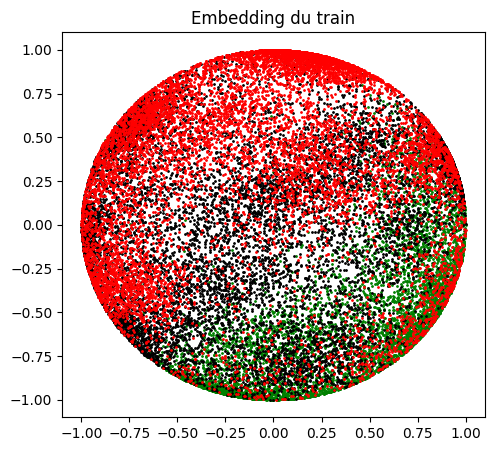

In [63]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green']
for i in range(58):
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

/tmp/ipykernel_14534/2906242975.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)


(-1.0999793082475662, 1.099931326508522, -1.09995396733284, 1.0993047535419465)

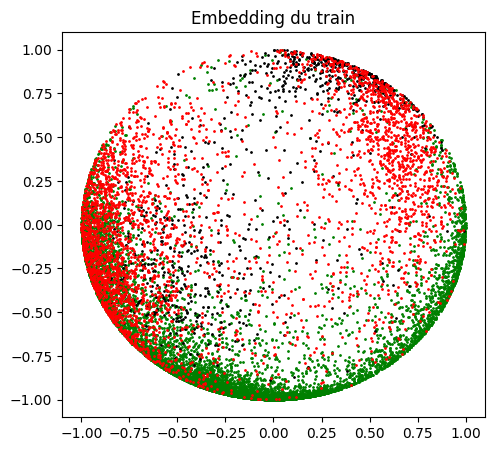

In [64]:
#dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
a,b,c = fc_test_cat.shape
data = fc_test_cat.resize(a*b,c).type(torch.float32)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green']
for i in range(28):
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

## MLP baseline

In [101]:
net = package.torch_classifier.MLP2(input_dim = 3321,output_dim = 3)
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
X = data.reshape((-1,3321)).numpy()
y = labels_train.reshape((-1))

d,e,f = dfc_test_vector.shape
data = dfc_test_vector.resize(d*e,f)
X_test = data.reshape((-1,3321)).numpy()
y_test = labels_train.reshape((-1))

#X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
train = package.torch_classifier.SimpleDataset(X,y)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 3, n_samples = 500)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

/volatile/aurelien_stumpf_mascles/project/env/lib/python3.8/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [102]:
package.torch_classifier.Train(net,train_loader,test_loader,100,lr = 0.1)

Train loss 1.0988, Train accuracy 33.33%
Test accuracy 7.10%
Train loss 0.0001, Train accuracy 100.00%
Test accuracy 62.03%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 61.39%


KeyboardInterrupt: 

In [103]:
net.eval()
for session in range(28):
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, dfc_test_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(dfc_test_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_test[session,0],res,probas.detach().numpy()))

True label : 2, Predicted label : 2, Probas : [0.05041769 0.05814667 0.8914356 ]
True label : 2, Predicted label : 0, Probas : [0.5309632  0.08448418 0.38455266]
True label : 2, Predicted label : 2, Probas : [0.11601953 0.19441824 0.68956226]
True label : 2, Predicted label : 2, Probas : [0.08067114 0.04033228 0.8789966 ]
True label : 2, Predicted label : 2, Probas : [1.3169473e-02 5.1524142e-07 9.8683000e-01]
True label : 2, Predicted label : 2, Probas : [0.00967707 0.02025976 0.9700631 ]
True label : 2, Predicted label : 2, Probas : [0.00409284 0.01354656 0.9823606 ]
True label : 2, Predicted label : 2, Probas : [2.7615625e-02 2.0693738e-05 9.7236371e-01]
True label : 2, Predicted label : 2, Probas : [0.0509904  0.05950163 0.88950795]
True label : 2, Predicted label : 2, Probas : [0.07236379 0.09322195 0.8344143 ]
True label : 2, Predicted label : 2, Probas : [0.06304396 0.10587059 0.83108544]
True label : 2, Predicted label : 2, Probas : [8.8983126e-02 2.9019113e-05 9.1098785e-01]
T

In [104]:
torch.save(net.state_dict(), '/volatile/aurelien_stumpf_mascles/project/models/condition_classifier.pth')